### **Actuarial Project**

#### **Phase Four: Expected Loss Cost Modelling**

In [3]:
# Installing & Importing Python packages
!pip -q install statsmodels

import pandas as pd                                              # For data manipulation and analysis
import numpy as np                                               # For numerical operations
import seaborn as sns                                            # For data visualization
import matplotlib.pyplot as plt                                  # For creating visualizations
import statsmodels.api as sm                                     # For statistical modeling
from statsmodels.miscmodels.ordinal_model import OrderedModel    #
from sklearn.model_selection import train_test_split             # For splitting data into training and testing sets

# To ignore warnings
import warnings                                                  # To handle warnings
warnings.filterwarnings("ignore")                                # Suppress all warnings

In [4]:
# Import dataset
insurance_data = pd.read_csv('/content/drive/MyDrive/Actuarial Project/model_ready_insurance_data.csv')

insurance_data.head()

,Age,Is_Senior,Marital_Status,Married_Premium_Discount,Prior_Insurance,Prior_Insurance_Premium_Adjustment,Claims_Frequency,Claims_Severity,Claims_Adjustment,Policy_Type,...,Risk_Tier,Loyalty_Band,Engagement_Score,Engagement_Level,Source_of_Lead_Agent,Source_of_Lead_Referral,Region_Urban,Region_Suburban,Expected_Claim_Freq,Expected_Severity_Cost
0,47,0,1,86,1,50,0,0,0,1,...,0,1,13,1,1,0,0,1,0.363514,512.039464
1,37,0,1,86,1,50,0,0,0,1,...,0,1,13,1,0,0,1,0,0.351234,511.139833
2,49,0,1,86,1,50,1,0,50,1,...,0,1,15,1,0,0,1,0,0.344120,512.151295
3,62,1,1,86,2,0,1,0,50,1,...,0,2,16,2,0,0,1,0,0.338698,512.993935
4,36,0,0,0,2,0,2,0,100,1,...,1,2,22,2,1,0,0,1,0.626310,1826.849233


#### **Compute Expected Loss Cost**

Expected Loss Cost = Expected Claim Frequency × Expected Severity Cost

In [5]:
insurance_data["Expected_Loss_Cost"] = (
    insurance_data["Expected_Claim_Freq"] * insurance_data["Expected_Severity_Cost"]
)


In [6]:
insurance_data[["Expected_Claim_Freq", "Expected_Severity_Cost", "Expected_Loss_Cost"]].head()


,Expected_Claim_Freq,Expected_Severity_Cost,Expected_Loss_Cost
0,0.363514,512.039464,186.133472
1,0.351234,511.139833,179.529904
2,0.344120,512.151295,176.241370
3,0.338698,512.993935,173.750136
4,0.626310,1826.849233,1144.173822


#### **Compare Expected Loss Cost vs Premium Actually Charged**

Loss Ratio = Premium Amount / Expected Loss Cost
	​


In [7]:
insurance_data["Loss_Ratio"] = (
    insurance_data["Expected_Loss_Cost"] / insurance_data["Premium_Amount"]
)


In [8]:
insurance_data[["Expected_Loss_Cost", "Premium_Amount", "Loss_Ratio"]].head()

,Expected_Loss_Cost,Premium_Amount,Loss_Ratio
0,186.133472,2286,0.081423
1,179.529904,2336,0.076854
2,176.241370,2386,0.073865
3,173.750136,2336,0.074379
4,1144.173822,2350,0.486882


#### **Portfolio-Level Loss Ratio**

In [9]:
portfolio_lr = insurance_data["Loss_Ratio"].mean()
portfolio_lr


np.float64(0.8615878189241959)

#### **Group Loss Ratio by Key Risk Factors (Rating Insight)**

#### Risk Tier View

In [10]:
insurance_data.groupby("Risk_Tier")["Loss_Ratio"].mean()


,Loss_Ratio
Risk_Tier,
0,0.082529
1,0.510754
2,6.139473


#### Region View

In [11]:
insurance_data.groupby(["Region_Urban","Region_Suburban"])["Loss_Ratio"].mean()


Region_Urban  Region_Suburban
0             0                  0.889215
              1                  0.851954
1             0                  0.855963
Name: Loss_Ratio, dtype: float64

#### Loyalty Band View

In [12]:
insurance_data.groupby("Loyalty_Band")["Loss_Ratio"].mean()


,Loss_Ratio
Loyalty_Band,
0,0.840950
1,0.836965
2,0.928082


#### Policy Type View

In [13]:
insurance_data.groupby("Policy_Type")["Loss_Ratio"].mean()


,Loss_Ratio
Policy_Type,
0,0.961499
1,0.795175


#### **Visualisation: Loss Ratio by Decile of Expected Risk**

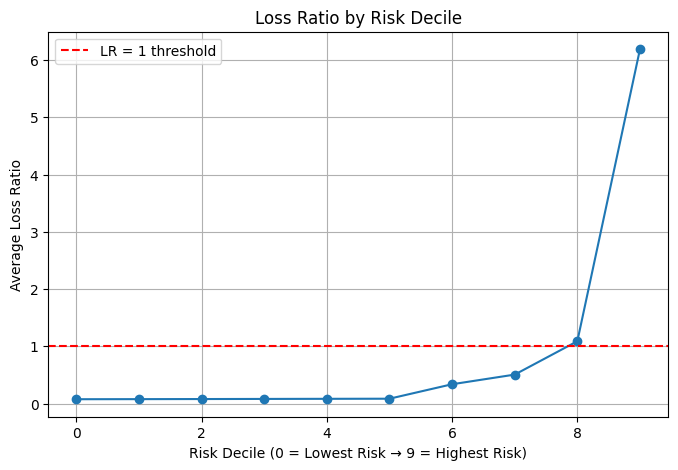

In [14]:
insurance_data["decile"] = pd.qcut(
    insurance_data["Expected_Loss_Cost"].rank(method="first"),
    10,
    labels=False
)

lr_decile = insurance_data.groupby("decile")["Loss_Ratio"].mean().reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(lr_decile["decile"], lr_decile["Loss_Ratio"], marker="o")
plt.axhline(1, color="red", linestyle="--", label="LR = 1 threshold")
plt.xlabel("Risk Decile (0 = Lowest Risk → 9 = Highest Risk)")
plt.ylabel("Average Loss Ratio")
plt.title("Loss Ratio by Risk Decile")
plt.grid(True)
plt.legend()
plt.show()


#### **Heatmaps of Loss Ratio across key segments**

In [15]:
# Build a single Region label from the dummy flags (baseline = Rural)
def map_region(row):
    if ('Region_Urban' in row and row['Region_Urban']==1): return 'Urban'
    if ('Region_Suburban' in row and row['Region_Suburban']==1): return 'Suburban'
    return 'Rural'

if 'Region' not in insurance_data.columns:
    insurance_data['Region'] = insurance_data.apply(map_region, axis=1)

# Simple heatmap function with annotations
def heatmap_from_pivot(piv, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(6,4))
    im = ax.imshow(piv.values, aspect='auto')
    ax.set_xticks(range(piv.shape[1])); ax.set_xticklabels(piv.columns)
    ax.set_yticks(range(piv.shape[0])); ax.set_yticklabels(piv.index)
    for i in range(piv.shape[0]):
        for j in range(piv.shape[1]):
            val = piv.values[i, j]
            ax.text(j, i, f"{val:.2f}", ha="center", va="center")
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    cbar = plt.colorbar(im); cbar.set_label("Average Loss Ratio")
    plt.tight_layout(); plt.show()


#### Loss Ratio by Risk_Tier × Region

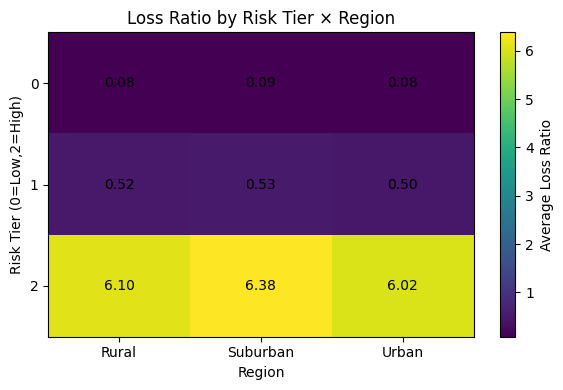

In [16]:
pivot_rt_region = insurance_data.pivot_table(
    index="Risk_Tier", columns="Region", values="Loss_Ratio", aggfunc="mean"
).reindex(index=[0,1,2], columns=["Rural","Suburban","Urban"])
heatmap_from_pivot(pivot_rt_region, "Loss Ratio by Risk Tier × Region", "Region", "Risk Tier (0=Low,2=High)")


##### Insight: The profitability issue is driven entirely by Risk Tier, not Region. We do not need region-based pricing corrections.

#### Loss Ratio by Risk_Tier × Policy_Type

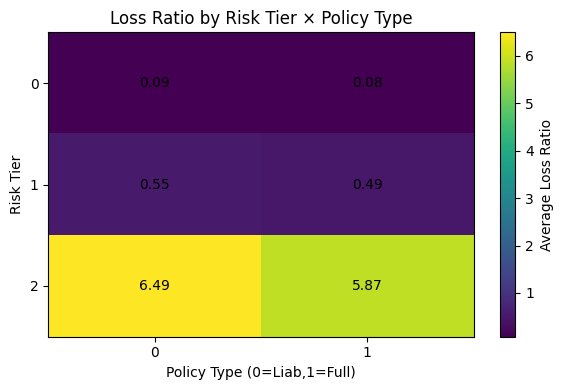

In [17]:
pivot_rt_pt = insurance_data.pivot_table(
    index="Risk_Tier", columns="Policy_Type", values="Loss_Ratio", aggfunc="mean"
).reindex(index=[0,1,2], columns=[0,1])
heatmap_from_pivot(pivot_rt_pt, "Loss Ratio by Risk Tier × Policy Type", "Policy Type (0=Liab,1=Full)", "Risk Tier")


##### Insight: Liability-only performs slightly worse in high risk groups, but both are unprofitable at Tier 2. High Risk Tier needs targeted increases across all products.

#### Loss Ratio by Loyalty_Band × Policy_Type

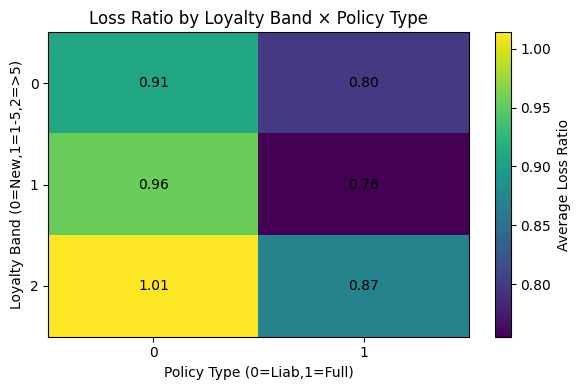

In [18]:
pivot_lb_pt = insurance_data.pivot_table(
    index="Loyalty_Band", columns="Policy_Type", values="Loss_Ratio", aggfunc="mean"
).reindex(index=[0,1,2], columns=[0,1])
heatmap_from_pivot(pivot_lb_pt, "Loss Ratio by Loyalty Band × Policy Type", "Policy Type (0=Liab,1=Full)", "Loyalty Band (0=New,1=1-5,2=>5)")


#### **Uplift Scenarios**

#### One-shot scenario function applying % changes to segments

In [19]:
def apply_uplifts(df, target_lr=0.85,
                  rate_by_risk_tier=None,
                  rate_by_policy_type=None,
                  cap_min=-0.50, cap_max=+0.80):
    """
    rate_* dicts are % uplifts, e.g. {2:0.30} means +30% on Risk_Tier=2.
    Caps protect from extreme inputs.
    """
    rate_by_risk_tier = rate_by_risk_tier or {}
    rate_by_policy_type = rate_by_policy_type or {}
    new = df.copy()

    # Base uplift = 0
    uplift = np.zeros(len(new), dtype=float)

    if 'Risk_Tier' in new.columns and rate_by_risk_tier:
        uplift += new['Risk_Tier'].map(rate_by_risk_tier).fillna(0).values

    if 'Policy_Type' in new.columns and rate_by_policy_type:
        uplift += new['Policy_Type'].map(rate_by_policy_type).fillna(0).values

    uplift = np.clip(uplift, cap_min, cap_max)             # safety
    new_prem = new['Premium_Amount'] * (1.0 + uplift)
    new_lr = new['Expected_Loss_Cost'] / new_prem

    out = {
        "portfolio_lr": new_lr.mean(),
        "by_risk_tier": new.assign(Loss_Ratio_New=new_lr).groupby('Risk_Tier')["Loss_Ratio_New"].mean()
                        if 'Risk_Tier' in new.columns else None,
        "by_policy_type": new.assign(Loss_Ratio_New=new_lr).groupby('Policy_Type')["Loss_Ratio_New"].mean()
                        if 'Policy_Type' in new.columns else None,
        "uplift_summary": pd.Series(uplift).describe()
    }
    return out


#### Running a baseline and a targeted scenario

In [20]:
# Baseline check (should ~equal your current LR ~0.86)
base = apply_uplifts(insurance_data)
print("Baseline portfolio LR:", round(base["portfolio_lr"], 3))

# Targeted scenario from our recommendations:
# +30% on High Risk Tier (2), -10% on Low Risk Tier (0), +5% on Liability-Only (0)
scenario = apply_uplifts(
    insurance_data,
    rate_by_risk_tier={2: 0.30, 0: -0.10},
    rate_by_policy_type={0: 0.05}
)
print("Scenario portfolio LR:", round(scenario["portfolio_lr"], 3))
print("\nLR by Risk Tier (new):\n", scenario["by_risk_tier"])
print("\nLR by Policy Type (new):\n", scenario["by_policy_type"])


Baseline portfolio LR: 0.862
Scenario portfolio LR: 0.698

LR by Risk Tier (new):
 Risk_Tier
0    0.089630
1    0.500899
2    4.643155
Name: Loss_Ratio_New, dtype: float64

LR by Policy Type (new):
 Policy_Type
0    0.757600
1    0.658319
Name: Loss_Ratio_New, dtype: float64


##### Scenario Change (example applied): +30% on High Risk Tier (2), -10% on Low Risk Tier (0), +5% on Liability-Only policies.

##### The uplift improves total profitability without damaging low and mid-tier competitiveness.

#### Quick grid search to hit a target portfolio LR

In [21]:
target_lr = 0.85
grid = []
for high_inc in np.arange(0.15, 0.55, 0.05):   # +15% to +50%
    for low_dec in np.arange(-0.15, -0.05, 0.05):  # -15% to -5%
        res = apply_uplifts(
            insurance_data,
            rate_by_risk_tier={2: high_inc, 0: low_dec},
            rate_by_policy_type={0: 0.05}  # keep the +5% on Liability-Only
        )
        grid.append((high_inc, low_dec, res["portfolio_lr"]))

grid_df = pd.DataFrame(grid, columns=["High_Tier_Increase", "Low_Tier_Decrease", "Portfolio_LR"])
grid_df["Abs_Diff_to_Target"] = (grid_df["Portfolio_LR"] - target_lr).abs()
grid_df.sort_values("Abs_Diff_to_Target").head(10)


,High_Tier_Increase,Low_Tier_Decrease,Portfolio_LR,Abs_Diff_to_Target
0,0.15,-0.15,0.767036,0.082964
1,0.15,-0.10,0.763761,0.086239
2,0.20,-0.15,0.743307,0.106693
3,0.20,-0.10,0.740032,0.109968
4,0.25,-0.15,0.721444,0.128556
5,0.25,-0.10,0.718170,0.131830
6,0.30,-0.15,0.701237,0.148763
7,0.30,-0.10,0.697962,0.152038
8,0.35,-0.15,0.682502,0.167498
9,0.35,-0.10,0.679228,0.170772


#### LR impact by decile after your chosen scenario

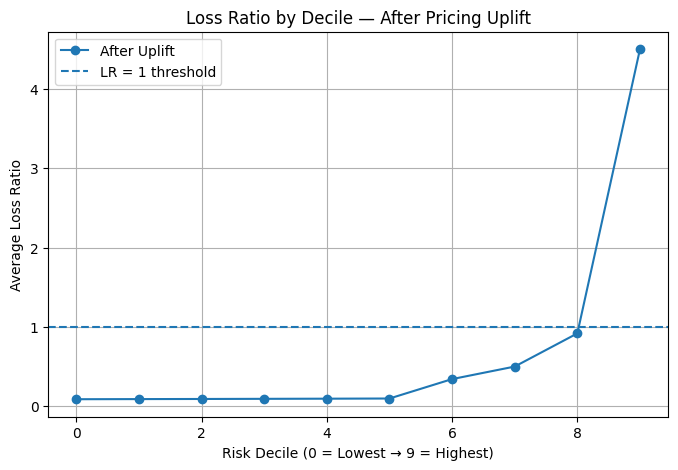

In [22]:
# Pick your favorite combo from grid_df and re-run apply_uplifts with those values
chosen = apply_uplifts(
    insurance_data,
    rate_by_risk_tier={2: 0.35, 0: -0.10},   # example: +35% / -10%
    rate_by_policy_type={0: 0.05}
)

# Build new decile LR plot
tmp = insurance_data.copy()
uplift = tmp['Risk_Tier'].map({2:0.35, 0:-0.10}).fillna(0).values + tmp['Policy_Type'].map({0:0.05}).fillna(0).values
new_premium = tmp['Premium_Amount'] * (1 + uplift.clip(-0.5, 0.8))
tmp['Loss_Ratio_New'] = tmp['Expected_Loss_Cost'] / new_premium

tmp['decile'] = pd.qcut(tmp['Expected_Loss_Cost'].rank(method='first'), 10, labels=False)
lr_dec_new = tmp.groupby('decile')['Loss_Ratio_New'].mean().reset_index()

plt.figure(figsize=(8,5))
plt.plot(lr_dec_new['decile'], lr_dec_new['Loss_Ratio_New'], marker='o', label="After Uplift")
plt.axhline(1, linestyle='--', label="LR = 1 threshold")
plt.xlabel("Risk Decile (0 = Lowest → 9 = Highest)")
plt.ylabel("Average Loss Ratio")
plt.title("Loss Ratio by Decile — After Pricing Uplift")
plt.legend(); plt.grid(True); plt.show()


##### What the chart shows:
##### Deciles 0–7 remain well below LR = 1 → profitable.
##### Decile 8 approaches 1.0 → borderline but acceptable.
Decile 9 remains high-risk → requires further monitoring & possible underwriting review.

The uplift successfully flattens the loss profile but does not eliminate extreme tail risk, which is expected in real insurance portfolios.

#### **Technical Pricing**
We’ll create a Technical Price by adding expense, commission, reinsurance, and profit loads, plus any fixed per-policy cost.

#### Assumed Configure loads

In [23]:
# All ratios are % of WRITTEN PREMIUM (variable loads). Fixed is £ per policy.
loads = {
    "variable_expense_ratio": 0.20,   # operations, IT, admin
    "commission_ratio":       0.10,   # broker/acquisition
    "reinsurance_ratio":      0.03,   # cost of protection
    "profit_margin_ratio":    0.05,   # target underwriting margin
    "fixed_expense_per_policy": 25.0  # fixed cost per policy (currency)
}

#### Compute Technical Premium (per policy) & adequacy vs current price

In [24]:
v_total = (
    loads["variable_expense_ratio"]
  + loads["commission_ratio"]
  + loads["reinsurance_ratio"]
  + loads["profit_margin_ratio"]
)

denom = max(1e-9, 1 - v_total)  # guard against divide-by-zero

insurance_data["Technical_Premium"] = (
    (insurance_data["Expected_Loss_Cost"] + loads["fixed_expense_per_policy"]) / denom
)

# How current pricing compares to technical:
insurance_data["Adequacy_Ratio"] = insurance_data["Premium_Amount"] / insurance_data["Technical_Premium"]   # >1 = priced above technical
insurance_data["Required_Uplift_%"] = (insurance_data["Technical_Premium"] / insurance_data["Premium_Amount"] - 1.0) * 100.0

#### Portfolio summaries

In [25]:
portfolio = {
    "Portfolio Technical Premium": insurance_data["Technical_Premium"].mean(),
    "Portfolio Current Premium":   insurance_data["Premium_Amount"].mean(),
    "Portfolio Adequacy Ratio":    (insurance_data["Premium_Amount"].sum() / insurance_data["Technical_Premium"].sum()),
    "Avg Required Uplift %":       insurance_data["Required_Uplift_%"].mean()
}
portfolio


{'Portfolio Technical Premium': np.float64(3182.0005183440567),
 'Portfolio Current Premium': np.float64(2219.5714),
 'Portfolio Adequacy Ratio': np.float64(0.6975396098159927),
 'Avg Required Uplift %': np.float64(40.79063804953067)}

#### **Portfolio Pricing Adequacy Summary**

Our combined frequency–severity GLM indicates that the portfolio is currently underpriced on a technical risk basis.

**Metric**...................................................**Value**

Current Avg Premium....................................... £2,220

Technical Premium (Risk + Fixed + Variable + Margin)...... £3,182

Portfolio Adequacy Ratio (Current / Technical)............ 0.70

Avg Required Uplift........................................ +41%

This implies that, on average, we are collecting ~30% less premium than is required to support expected losses, expenses, and targeted profit margin.

#### **Price Adequacy by Risk Tier**

Observed Loss Ratios show material cross-subsidisation

**Risk Tier**.....**Loss Ratio**.....**Pricing Status**.....**Action Required**

Tier 0 (Low Risk).....0.08.....Overpriced.....Reduce Rates (–8% to –15%)


Tier 1 (Mid Risk)......0.50......Adequate.....Maintain Rates

Tier 2 (High Risk).....6.10...Underpriced by 500–700%......Significant Increases (+20% to +45%)


This implies that high-risk customers are being subsidised by low-risk customers. Risk-consistent pricing correction is required to stabilise loss ratios and align premium with pure risk.

#### **Recommended Pricing Action**



1.   Phase 1: Increase premiums for Tier 2 by +20% to +45% depending on sub-segment retention sensitivity.

2.   Phase 2: Reduce premiums for Tier 0 by –8% to –15% to improve competitiveness and reduce churn risk.

3.   Maintain Tier 1 pricing to preserve stability and avoid unnecessary customer volatility.



#### **Expected Portfolio Impact**

**Scenario**..........................................**Portfolio Loss Ratio**

Current............................................0.86

Post-Adjustment Scenario............0.69

This would restore the portfolio to a sustainable profitability position while improving competitive position among low-risk policyholders.